## KTO Parametric Amplifier Simulation - Solving Equations of Motion


In [1]:
# Import packages

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Definition of Parameters and Functions

In [5]:
# Define parameters

C = 1/50    # Capacitance
Z = 800   # Impedance
L_0 = 50    # Base inductance
L_p = 0.6  # Amplitude of inductance oscillation
omega = 1.0 # Frequency for the sinusoidal functions

# Define input function and the time varying inductance

# Define phi_in_dot(t) as a function of time
def phi_in_dot(t):
    return 1 * np.sin(omega * t + np.pi/2)

# Define phi_in(t) as the integral of phi_in_dot(t)
def phi_in(t):
    return -1 / omega * np.cos(omega * t + np.pi/2)

# Define L(t) as a function of time
def L(t):
    return L_0 + L_p * np.sin(2 * omega * t)

# Define the system of ODEs
def circuit_equations(y, t):
    phi_net, phi_net_dot = y
    phi_net_ddot = - (phi_net_dot / (C * Z)) - (phi_net / (C * L(t))) + (2 * phi_in_dot(t) / (C * Z))
    
    return [phi_net_dot, phi_net_ddot]

y0 = [0, 0] # Initial conditions


### Gain Calculation (Theoretical)

$$
G = \frac{A_{out}^2}{A_{in}^2} = \frac{(\frac{2K}{\omega}+\frac{L_P}{L_0})^2}{(\frac{2K}{\omega}-\frac{L_P}{L_0})^2}
$$

In [6]:
# Gain calculation (theoretical)

def calc_thoretical_gain(C=C, Z=Z, L_0=L_0, L_p=L_p, omega=omega):
    K = 1/(C*Z)
    gain = (((2*K/omega) + L_p/L_0)/((2*K/omega) - L_p/L_0))**2
    return gain

print(calc_thoretical_gain())

1.4698880100242777


### Solution

In [7]:
# Solving the ODE

# Define the time array
t = np.linspace(0, 400, 10000)

# Solve the ODE using odeint
solution = odeint(circuit_equations, y0, t)

# Extract the solutions for phi_net(t) and phi_net_dot(t)
phi_net = solution[:, 0]
phi_net_dot = solution[:, 1]

phi_in_vals = phi_in(t)
phi_out_vals = phi_in_vals - phi_net

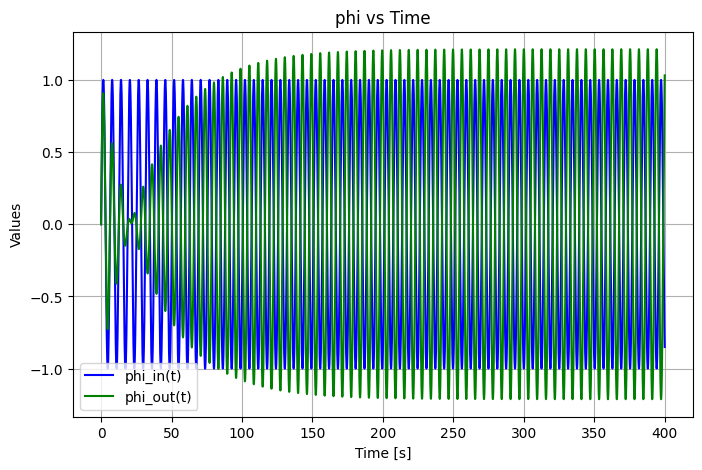

In [8]:
# Plot the solution for phi_out(t)
plt.figure(figsize=(8, 5))
plt.plot(t, phi_in_vals, label="phi_in(t)", color="blue")
plt.plot(t, phi_out_vals, label="phi_out(t)", color="green")
plt.xlabel('Time [s]')
plt.ylabel('Values')
plt.title('phi vs Time')
plt.legend()
plt.grid(True)
plt.show()

### FFT Calculation

$\phi_{out}$ signal will comprise of two frequencies- $\omega$ and $2 \omega$.  

Here I will follow the following steps to extract the $\omega$ component from the signal:
1. Extract a portion (typically 2/3 periods) of the $\phi_{out}$ signal where the system has reached equillibrium oscillations.
2. Pick time values corresponding to $\omega$ as follows:
$$
T = n\frac{2\pi}{\omega}, \quad \Delta t = T/N
$$
where $n$ is the number of periods wanted, $\Delta t$ is the step size and $N$ is the number of divisions.  
3. Calculate the modified $\phi_{out}$ at these time points.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


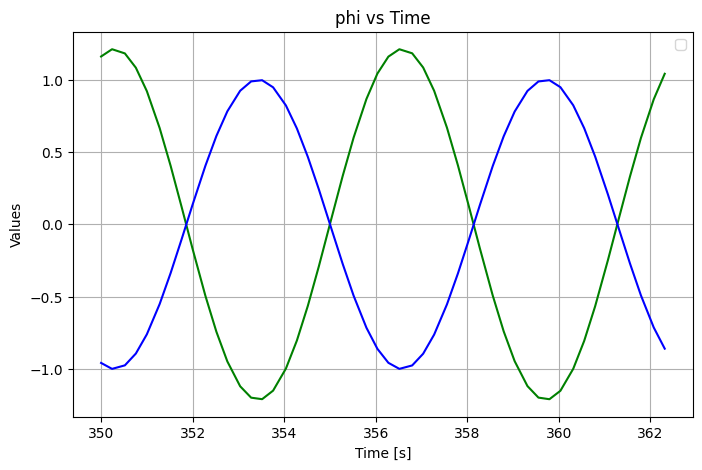

In [9]:
n_periods = 2
sat_point = 350
n_divisions = 50
period = n_periods * 2 * np.pi / omega
step_size = period / n_divisions

idx = []
phi_out_mod = []
phi_in_mod = []
t_mod = []
for i in range(n_divisions):
    inc = sat_point + i*step_size
    idx.append(int((np.abs(t - inc)).argmin()))
    phi_out_mod.append(phi_out_vals[idx[i]])
    phi_in_mod.append(phi_in_vals[idx[i]])
    t_mod.append(t[idx[i]])

# Plot the modified solution for phi_out(t) and phi_in(t)
plt.figure(figsize=(8, 5))
plt.plot(t_mod, phi_out_mod, color="green")
plt.plot(t_mod, phi_in_mod, color="blue")
plt.xlabel('Time [s]')
plt.ylabel('Values')
plt.title('phi vs Time')
plt.legend()
plt.grid(True)
plt.show()


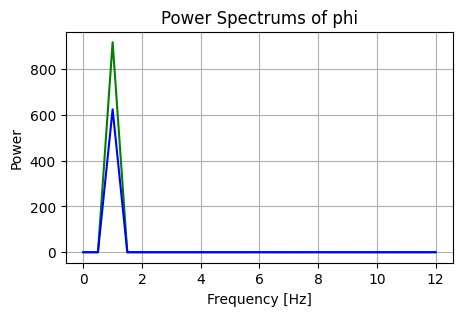

In [11]:
# FFT Calculation

phi_out_fft = np.fft.fft(phi_out_mod)
phi_in_fft = np.fft.fft(phi_in_mod)

# Frequencies corresponding to the FFT components
frequencies = np.fft.fftfreq(n_divisions, step_size)
frequencies_hz = frequencies * 2 * np.pi

# Power spectrum (magnitude of the Fourier transform)
ps_phi_out = np.abs(phi_out_fft)**2
ps_phi_in = np.abs(phi_in_fft)**2

# Plot the power spectrum (only positive frequencies)
plt.figure(figsize=(5, 3))
plt.plot(frequencies_hz[:len(frequencies)//2], ps_phi_out[:len(frequencies)//2], color='green')
plt.plot(frequencies_hz[:len(frequencies)//2], ps_phi_in[:len(frequencies)//2], color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power Spectrums of phi')
plt.grid(True)
plt.show()

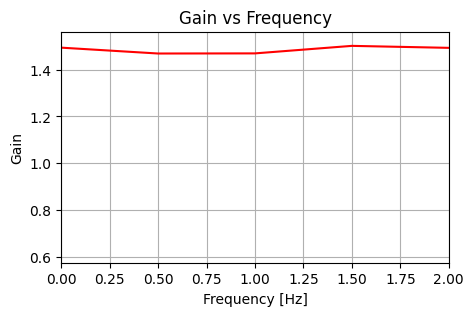

In [12]:
# Gain curve

gain = ps_phi_out / ps_phi_in

plt.figure(figsize=(5, 3))
plt.plot(frequencies_hz[:len(frequencies)//2], gain[:len(frequencies)//2], color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.xlim(0, 2)
plt.title('Gain vs Frequency')
plt.grid(True)
plt.show()
